<div class="alert alert-info">
Ссылка для просмотра ноутбука в интерактивном режиме для использования гиперссылок и корректного отображения разметки:<br>
<a href='https://nbviewer.org/github/yulianikola/portfolio/blob/master/data_analysis_python/6_log_regression/adult.ipynb'>adult</a></div>

### Логистическая регрессия

#### Данные о доходе взрослых
http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

#### Задачи:
1. Ответить на вопросы по данным
1. Построить модель логистической регрессии, которая предсказывает уровень дохода человека

<p id="0">
<h4>Содержимое</h4>
<ul type="square"><a href="#1"><li>Знакомство с данными</li></a>
<a href="#2"><li>Эксплоративный анализ</li></a>
<a href="#3"><li>Отбор факторов</li></a>
<a href="#4"><li>Логистическая регрессия</li></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<p id="1">
<h4>Знакомство с данными</h4>

In [2]:
data = pd.read_csv('C:\\python\\portfolio\\data_analysis_python\\6_log_regression\\data\\adult.csv')
data.columns = data.columns.str.replace("-", "_")
data.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


В датасете 48842 строки, 15 столбцов. Пропусков нет. Типы данных определились корректно. Но в превью данных видны знаки вопросов,  судя по описанию датасета это пропуски.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational_num  48842 non-null  int64 
 5   marital_status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital_gain     48842 non-null  int64 
 11  capital_loss     48842 non-null  int64 
 12  hours_per_week   48842 non-null  int64 
 13  native_country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Проверим в каких столбцах есть вопросительные знаки:

In [4]:
for col in data.select_dtypes('object').columns:
    if '?' in data[col].values:
        print(col)

workclass
occupation
native_country


Удалим строки с пропусками. Как и в описании датасета, осталось 45222 строк:

In [5]:
data = data.drop(data[(data.workclass == '?') | (data.occupation == '?') | (data.native_country == '?')].index)
len(data)

45222

В данных 9 категориальных номинальных показателей, в т.ч. таргет:

In [6]:
data.select_dtypes('object').columns

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'gender', 'native_country', 'income'],
      dtype='object')

Числовых показателей 6. Посмотрим на их статистики. Показатель fnlwgt - вес, для скольки человек репрезентативно. Показатель educational_num - числовая кодировка education.

In [7]:
pd.set_option("precision", 3)
data.describe()

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
count,45222.000,4.522e+04,45222.000,45222.00,45222.000,45222.000
mean,38.548,1.897e+05,10.118,1101.43,88.595,40.938
std,13.218,1.056e+05,2.553,7506.43,404.956,12.008
min,17.000,1.349e+04,1.000,0.00,0.000,1.000
25%,28.000,1.174e+05,9.000,0.00,0.000,40.000
50%,37.000,1.783e+05,10.000,0.00,0.000,40.000
75%,47.000,2.379e+05,13.000,0.00,0.000,45.000
max,90.000,1.490e+06,16.000,99999.00,4356.000,99.000


В статистиках странно выглядят значения capital_gain и capital_loss, 75% значений это ноль. Посмотрим, какие они принимают значения. Большая часть значений это ноль, а в остальном признаки можно считать непрерывными:

In [8]:
data.capital_gain.value_counts()

0        41432
15024      498
7688       391
7298       351
99999      229
         ...  
22040        1
1731         1
7262         1
1639         1
2387         1
Name: capital_gain, Length: 121, dtype: int64

In [9]:
data.capital_loss.value_counts()

0       43082
1902      294
1977      246
1887      228
2415       68
        ...  
419         1
155         1
1539        1
2201        1
1421        1
Name: capital_loss, Length: 97, dtype: int64

Посмотрим на боксплоты числовых показателей. У всех есть выбросы.

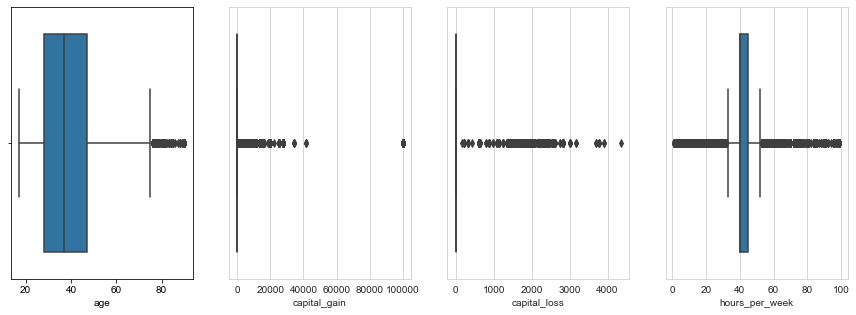

In [10]:
l = ['age', 'capital_gain', 'capital_loss','hours_per_week']
number_of_columns =  4
number_of_rows = - (- len(l) // number_of_columns) # round up
plt.figure(figsize = (15, 5))
for i in range(0, len(l)):
    plt.subplot(number_of_rows, number_of_columns, i + 1)
    sns.set_style('whitegrid')
    sns.boxplot(x = data[l[i]], data = data)

Посмотрим на распределения:

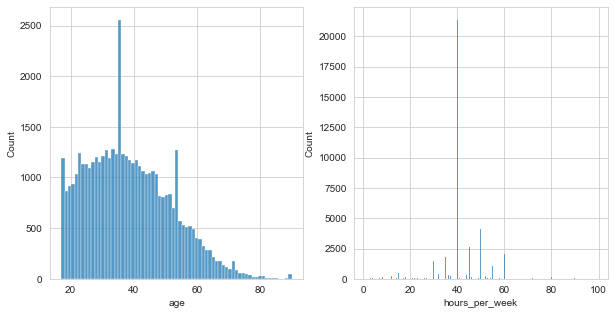

In [11]:
l = ['age', 'hours_per_week']
number_of_columns =  2
plt.figure(figsize = (10, 5))
for i in range(0, len(l)):
    plt.subplot(number_of_rows, number_of_columns, i + 1)
    sns.histplot(data[l[i]])

Распределение таргета: 25% доход более 50К и 75% менее 50к.

In [12]:
data.income.value_counts(normalize = True)

<=50K    0.752
>50K     0.248
Name: income, dtype: float64

<a href="#0"><h4>Наверх</h4></a>

<p id="2">
<h4>Эксплоративный анализ</h4>

Сколько мужчин и женщин представлено в датасете? Мужчин 30527, женщин 14695.

In [13]:
data.gender.value_counts()

Male      30527
Female    14695
Name: gender, dtype: int64

Каков средний возраст женщин? Около 37 лет.

In [14]:
round(data[data.gender == 'Female']['age'].mean(),2)

36.98

Какая доля граждан Германии? 0.4 %

In [15]:
round(data.native_country.value_counts(normalize = True).Germany, 4)

0.0043

Среднее и ско возраста тех, кто зарабатывает более 50к  и тех кто меньше 50к?

In [16]:
data.groupby('income')['age'].agg(['mean','std']).rename(columns={'mean':'avg_age','std':'std_age'}).round(2)

,avg_age,std_age
income,,
<=50K,36.75,13.56
>50K,44.01,10.34


С каким образованием встречаются люди, зарабатывающие больше 50к ?

In [17]:
data[data.income == '>50K']['education'].value_counts()
data.loc[data.income == '>50K','education'].value_counts()
data.loc[data.income == '>50K','education'].unique()

array(['Assoc-acdm', 'Some-college', 'Prof-school', 'HS-grad', 'Masters',
       'Bachelors', 'Assoc-voc', 'Doctorate', '9th', '10th', '7th-8th',
       '11th', '5th-6th', '1st-4th', '12th', 'Preschool'], dtype=object)

Возрастная статистика по расам и полам:

In [18]:
data.groupby(['race','gender'])['age'].describe().round(2)

count   mean    std   min    25%   50%    75%  \
race               gender                                                    
Amer-Indian-Eskimo Female    166.0  36.53  12.73  17.0  27.00  35.0  46.00   
                   Male      269.0  36.27  10.64  17.0  29.00  35.0  43.00   
Asian-Pac-Islander Female    436.0  35.98  12.34  17.0  26.00  35.0  44.00   
                   Male      867.0  39.18  12.67  18.0  30.00  38.0  47.00   
Black              Female   2084.0  38.10  12.48  17.0  28.00  37.0  46.00   
                   Male     2144.0  37.89  12.64  17.0  28.00  36.0  46.00   
Other              Female    126.0  31.70  10.28  17.0  23.25  29.5  38.75   
                   Male      227.0  35.03  11.44  17.0  26.50  32.0  42.00   
White              Female  11883.0  36.89  13.98  17.0  25.00  35.0  46.00   
                   Male    27020.0  39.48  12.96  17.0  30.00  38.0  48.00   

                            max  
race               gender        
Amer-Indian-Eskimo Female  80.0  
                   Male    71.0  
Asian-Pac-Islander Female  81.0  
                   Male    90.0  
Black              Female  90.0  
                   Male    90.0  
Other              Female  64.0  
                   Male    77.0  
White              Female  90.0  
                   Male    90.0

Доля зарабатывающих больше 50к выше среди женатых или свободных мужчин? Среди женатых 45%, среди свободных 7%.

In [19]:
data_2 = data.copy()
data_2['married_single'] = data_2['marital_status'].apply(lambda x: 'married' if 'Married' in x else 'single')
pd.crosstab(data_2.income, data_2.married_single, normalize = 'columns')

married_single,married,single
income,,
<=50K,0.555,0.933
>50K,0.445,0.067


Сколько людей работают максимум часов в неделю? Какая доля зарабатывающих больше 50к среди них? Максимум часов в неделею работают 123 человка. Среди них 33% зарабатывают больше 50к. 

In [20]:
print(data.loc[data.hours_per_week == data.hours_per_week.max(),:].shape[0])
print(data.loc[data.hours_per_week == data.hours_per_week.max(),'income'].value_counts(normalize = True).round(2))

123
<=50K    0.67
>50K     0.33
Name: income, dtype: float64


Среднее число часов в неделю для зарабатывающих больше и меньше 50к в Японии?

In [21]:
pd.crosstab(data.income, data.native_country, values = data.hours_per_week, aggfunc = 'mean').round(2)['Japan']

income
<=50K    39.90
>50K     47.13
Name: Japan, dtype: float64

<a href="#0"><h4>Наверх</h4></a>

<p id="3">
<h4>Отбор факторов</h4>

Посмотрим взаимосвязь между числовыми факторами и категориальным таргетом на групповых средних и медианах. На глаз заметные практические различия средних и медиан только у age. Распределение capital_gain и capital_loss очень асимметричны, средние различаются, а медианы нет. У hours_per_week распределение сосредоточено вокруг значения 40, средние различаются, а медиана нет.

In [22]:
num_column = ['age', 'capital_gain', 'capital_loss','hours_per_week']
for col in num_column:
    print(col, 'mean_>50K: ', round(data[data.income == '>50K'][col].mean(),3),
          'mean_<=50K: ', round(data[data.income == '<=50K'][col].mean(),3))
    print(col, 'median_>50K: ', round(data[data.income == '>50K'][col].median(),3),
          'median_<=50K: ', round(data[data.income == '<=50K'][col].median(),3))
    print('')

age mean_>50K:  44.006 mean_<=50K:  36.749
age median_>50K:  43.0 median_<=50K:  34.0

capital_gain mean_>50K:  3991.792 mean_<=50K:  149.023
capital_gain median_>50K:  0.0 median_<=50K:  0.0

capital_loss mean_>50K:  193.487 mean_<=50K:  54.032
capital_loss median_>50K:  0.0 median_<=50K:  0.0

hours_per_week mean_>50K:  45.69 mean_<=50K:  39.372
hours_per_week median_>50K:  40.0 median_<=50K:  40.0



Проверим, какие из различий в средних статистически значимы с помощью двустороннего теста Т-теста Стьюдента (распределение факторов не похоже на нормальное, но у нас достаточный объем данных, так что положимся на ЦПТ). По все факторам отвержение нулевой гипотезы о равенстве средних, и довольно высокие тест-статистики.

In [23]:
import scipy.stats as stats

In [24]:
for col in num_column:
    t,p = stats.ttest_ind(data[data.income == '>50K'][col], data[data.income == '<=50K'][col])
    print(col,'stat=', round(t,2),', p=', round(p,4))

age stat= 51.89 , p= 0.0
capital_gain stat= 48.19 , p= 0.0
capital_loss stat= 31.97 , p= 0.0
hours_per_week stat= 49.61 , p= 0.0


Для категориальных факторов проведем тест Хи-квадрат. По всем факторам тест дает нулевое р-значение, то есть более чем достаточно аргументов для отвержения нулевой гипотезы о независимости. Наибольшая тест-статистика у relationship, далее education и occupation.

In [25]:
from scipy.stats import chi2_contingency

In [26]:
cat_column = data.select_dtypes('object').columns[:-1]

for col in cat_column:
    tab = pd.crosstab(data.income, data[col])
    stat, p, *_ = chi2_contingency(tab, correction = False)
    print(col, 'stat: ', stat.round(2), 'p-value: ', p.round(4))

workclass stat:  1207.26 p-value:  0.0
education stat:  5996.0 p-value:  0.0
marital_status stat:  9109.23 p-value:  0.0
occupation stat:  5415.14 p-value:  0.0
relationship stat:  9357.04 p-value:  0.0
race stat:  452.3 p-value:  0.0
gender stat:  2105.2 p-value:  0.0
native_country stat:  456.01 p-value:  0.0


Другой подход к выбору факторов по критерию mutual information, которая измеряет сокращение неопределенности для одной переменной при известном значении другой.

In [27]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

Кодируем значения таргета:

In [28]:
le = LabelEncoder()
le.fit( data.income )
income_enc = le.transform( data.income )

Кодируем категориальные нечисловые факторы (кроме education, так для него уже есть educational_num):

In [29]:
cat_column = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
oe = OrdinalEncoder()
oe.fit( data[cat_column])
cat_enc = oe.transform(data[cat_column])
cat_enc_df = pd.DataFrame( data = cat_enc, columns = cat_column)

Факторы не сильно отличаются друг от друга по значимости. Самые значимые - marital_status и relationship.

In [30]:
num_column = ['age', 'capital_gain', 'capital_loss','hours_per_week', 'educational_num']
fs = SelectKBest(score_func = mutual_info_classif, k ='all')
X = pd.concat([data[num_column].reset_index().drop(['index'], axis=1), cat_enc_df], axis = 1) 
y = income_enc
fs.fit(X, y)
X_fs = fs.transform(X)
for i in X.columns:
    print(f'{i}: {fs.scores_[list(X.columns).index(i)].round(5)}')

age: 0.06609
capital_gain: 0.08502
capital_loss: 0.0349
hours_per_week: 0.04098
educational_num: 0.06171
workclass: 0.01453
marital_status: 0.1122
occupation: 0.06226
relationship: 0.11401
race: 0.01125
gender: 0.02565
native_country: 0.012


Итак, построим логистическую регрессию по трем моделям:
* все факторы (кроме fnlwgt)
* age, relationship, educational_num и occupation (по результатам теста Стьюдента и Хи-квадрата)
* relationship, marital_status, capital_gain и occupation (по результатам mutual information)

<a href="#0"><h4>Наверх</h4></a>

<p id="4">
<h4>Логистическая регрессия</h4>

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

Сначала с помощью кросс-валидации выберем модель.

Создадим функцию, которая разбивает на обучающую/тестовую выборки (классы таргета не сбалансированы 25% vs 75%, поэтому при разделении на выборки применяем параметр stratify, а также shuffle), проводит кросс-валидацию регресcии на обучающей выборке (создает дамми для категориальных факторов, так как кроме education они не порядковые) и возвращает среднее и медиану метрик accuracy, precision, recall и f1.

In [32]:
def logreg_cross_val (X, y, cat_col, num_col):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                        random_state = 42, stratify =  y, shuffle = True)  
    
    trans = ColumnTransformer(transformers = [('cat', OneHotEncoder(), cat_col), 
                                              ('sc', StandardScaler(), num_col)], remainder = 'passthrough')
    
    pipe = Pipeline( [ ("tr", trans), ("log", LogisticRegression(max_iter = 700))] )
     
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
   
    scores_acc = cross_val_score(pipe, X_train, y_train, scoring = 'accuracy', cv = cv)

    scores_pr = cross_val_score(pipe, X_train, y_train, scoring = 'precision', cv = cv)

    scores_re = cross_val_score(pipe, X_train, y_train, scoring = 'recall', cv = cv)
    
    scores_f = cross_val_score(pipe, X_train, y_train, scoring = 'f1', cv = cv)

    return print('accuracy: средн=', round(np.mean(scores_acc),4), ', мед=', round(np.median(scores_acc),4),
                '\nprecision: средн=', round(np.mean(scores_pr),4), ', мед=', round(np.median(scores_pr),4),
                '\nrecall: средн=', round(np.mean(scores_re),4), ', мед=', round(np.median(scores_re),4),
                '\nf1-score: средн=', round(np.mean(scores_f),4), ', мед=', round(np.median(scores_f),4))

Модель 1 (все факторы)

In [33]:
col = ['age', 'workclass', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week']
cat_col = ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'gender']
num_col = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']

X = data[col]
y = LabelEncoder().fit_transform(data.income)

logreg_cross_val (X, y, cat_col, num_col)

accuracy: средн= 0.8491 , мед= 0.849 
precision: средн= 0.7365 , мед= 0.7347 
recall: средн= 0.6097 , мед= 0.6089 
f1-score: средн= 0.667 , мед= 0.666


Модель 2 (age, relationship, educational_num, occupation)

In [34]:
col = ['age', 'relationship', 'educational_num', 'occupation']
cat_col = ['relationship', 'occupation']
num_col = ['age']

X = data[col]
y = LabelEncoder().fit_transform(data.income)

logreg_cross_val (X, y, cat_col, num_col)

accuracy: средн= 0.8266 , мед= 0.8264 
precision: средн= 0.6931 , мед= 0.6911 
recall: средн= 0.5394 , мед= 0.5417 
f1-score: средн= 0.6065 , мед= 0.6063


Модель 3 (relationship, marital_status, capital_gain, occupation)

In [35]:
col = ['marital_status', 'relationship', 'capital_gain', 'occupation']
cat_col = ['relationship', 'marital_status', 'occupation']
num_col = ['capital_gain']

X = data[col]
y = LabelEncoder().fit_transform(data.income)

logreg_cross_val (X, y, cat_col, num_col)

accuracy: средн= 0.8347 , мед= 0.8337 
precision: средн= 0.7144 , мед= 0.7123 
recall: средн= 0.555 , мед= 0.5567 
f1-score: средн= 0.6246 , мед= 0.6266


Accuracy хороша для сбалансированных классов. В задаче с прогнозом уровня дохода сложно оценить, цена какой ошибки выше: False Negative или False Positive, поэтому сложно выбрать между Precision и Recall. Будем опираться на "среднее" между Precision и Recall - f1_score. По этой метрике модели не так сильно различаются, у модели со всеми (11) факторами метрика 0.66, у модели 3 (5 факторов) метрика 0.62. Поэтому остановимся на модели 3, так качество незначительно ниже, а модель значительно проще.

Теперь обучаем выбранную модель на всем трейне, кодируем категориальные факторы. 

In [36]:
col = ['marital_status', 'relationship', 'capital_gain', 'occupation']
cat_col = ['relationship', 'marital_status', 'occupation']
num_col = ['capital_gain']

X = data[col]
y = LabelEncoder().fit_transform(data.income)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                        random_state = 42, stratify =  y, shuffle = True)  

trans = ColumnTransformer(transformers = [('cat', OneHotEncoder(), cat_col),
                                         ('sc', StandardScaler(), num_col)], remainder = 'passthrough')
pipe = Pipeline( [("tr", trans)] )
                                 
pipe.fit(X_train)
X_train_enc = pipe.transform(X_train)
X_test_enc = pipe.transform(X_test)

lr = LogisticRegression(max_iter = 200)
lr.fit(X_train_enc, y_train)

LogisticRegression(max_iter=200)

Делаем прогнозы на тестовой выборке. Метрики получились чуть ниже, чем в кросс-валидации. f1_score для класса дохода <50к = 0.89, для дохода >50к = 0.59.

In [37]:
pred = lr.predict(X_test_enc)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89     10205
           1       0.68      0.53      0.59      3362

    accuracy                           0.82     13567
   macro avg       0.77      0.72      0.74     13567
weighted avg       0.81      0.82      0.81     13567



<a href="#0"><h4>Наверх</h4></a>